In [9]:
import pymongo
from dotenv import load_dotenv
import os

import sys
sys.path.append('../src/')
from utils.preprocess_transcription import remove_ads, identify_host, insert_marker_before_host
from utils.extract_comp_guest import re_extract_comp_guest

from langchain_openai import OpenAIEmbeddings
from langchain_community.chat_models import ChatAnthropic
from langchain_openai import ChatOpenAI, OpenAI
from langchain_mistralai.chat_models import ChatMistralAI

from typing import Annotated, Dict, TypedDict, Optional

from langchain_core.messages import BaseMessage

from langchain_core.prompts import PromptTemplate
# from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser, PydanticOutputParser
import os
import pprint

from utils.company_answer_extraction import retrieve, grade_documents, generate, transform_query, decide_to_generate

from langgraph.graph import END, StateGraph
load_dotenv()

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string
        retries: An optional integer representing the number of retries (default: 0)
        document_count: An optional integer representing the document count (default: 0)
        company: A string representing the company
    """
    keys: Dict[str, any]
    retries: Optional[int] = 1
    doc_pull_limit: Optional[int] = 4

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
# workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [3]:
client = pymongo.MongoClient(os.getenv('mdb_uri'))
DB_NAME = "hibt_prod_db"
COLLECTION_NAME = "hibt_prod_collection"
ATLAS_VECTOR_SEARCH_INDEX_NAME = "vector_index"
MONGODB_COLLECTION = client[DB_NAME][COLLECTION_NAME]
MONGODB_ANSWER_COLLECTION = client[DB_NAME]["hibt_answer_collection"]

In [ ]:
### This was for a smaller test of the code without having it loop through 248 companies.

# # each mongodb document has a key called "company" I would like to get 15 unique company names from the collection

# companies = MONGODB_COLLECTION.aggregate([
#     {"$sample": {"size": 5}},
#     {"$group": {"_id": "$company"}},
#     {"$project": {"_id": 0, "company": "$_id"}},
#     {"$limit": 15}
# ])
# companies = [company["company"] for company in companies]


# company_answers = {}
# # create remaining_keys as company for company in companies if its not in company_answer.keys()
# # remaining_keys = [company for company in companies if company not in company_answers.keys()]

# for company in companies:
#     inputs = {
#         "keys": {
#             "company": company,
#             "question": """
#             How much of your success do you think is because of luck and, and how much because of Either a hardworking skill.
#             """
#         },
#         "doc_pull_limit": 4,
#         "retries": 1,
#     }

#     answer = app.invoke(inputs)
#     company_answers[company] = answer['keys']['generation'].answer

# print(company_answers)


In [ ]:
# Get all of the unique company names in our mongodb collection.

companies = MONGODB_COLLECTION.aggregate([
    {"$group": {"_id": "$company"}},
    {"$project": {"_id": 0, "company": "$_id"}},
])
companies = [company["company"] for company in companies]

In [ ]:
import json
import os
from tqdm.notebook import tqdm

# Function to save company answers to a file
def save_company_answers(data, filepath="../answers/company_answers.json"):
    with open(filepath, "w") as f:
        json.dump(data, f)

# Load existing data if available
company_answers = {}
filepath = "../answers/company_answers.json"
if os.path.exists(filepath):
    with open(filepath, "r") as f:
        company_answers = json.load(f)

for i, company in enumerate(tqdm(companies, desc="Processing companies")):
    if company in company_answers:
        continue  # Skip if already processed

    inputs = {
        "keys": {
            "company": company,
            "question": """
            How much of your success do you think is because of luck, and how much because of either hardworking skill?
            """
        },
        "doc_pull_limit": 4,
        "retries": 1,
    }

    try:
        answer = app.invoke(inputs)
        company_answers[company] = answer['keys']['generation'].answer
        if (i + 1) % 10 == 0:  # Print every 10 companies
            print(f"{i + 1}: Processed {company} with generation: {answer['keys']['generation'].answer[:100]}...")  # Print a snippet of the generation
        save_company_answers(company_answers)  # Save after each successful company processing
    except Exception as e:
        print(f"Error processing {company}: {e}")
        company_answers[company] = {"error": str(e)}
        save_company_answers(company_answers)  # Save the state including errors

# Final save, in case it wasn't triggered in the loop
save_company_answers(company_answers)

In [ ]:
# read in "../answers/company_answers.json") into a pandas dataframe


with open("../answers/company_answers.json", "r") as f:
    company_answers = json.load(f)

df = pd.DataFrame(company_answers.items(), columns=["company", "answer"])

In [ ]:
from pydantic.v1 import BaseModel, Field

class AnswerGrade(BaseModel):
    summary: str
    luck: int
    work: int
    people: int


In [ ]:
summary_score_prompt = """
    You are a summary and topic extraction expert. You are provided with answers to a question "How much of your success do you think is because of luck, and how much because of either hardworking skill?" 
    and you are to summarize the answers focusing on their underlying topics. 

    You will also be required to score the answer based on three metrics:
    - luck: How much of the success is attributed to luck, 0 being no luck and 10 being all luck.
    - work: How much of the success is attributed to skill and hard work, 0 being no skill and 10 being all skill and hard work.
    - people: How much of the success is attributed to the people around them or their network, 0 being no people and 10 being all people.

    Here is the guests answer:

    {answer}

    You are to respond in json format with the following structure:
    {response_template}
"""

In [ ]:
def sum_grade_answer(answer: str) -> AnswerGrade:
    """
    This function takes in a string and returns a QuestionAnswer object with the summary and scores.
    """

    output_parser = PydanticOutputParser(pydantic_object=AnswerGrade)
    # Create the prompt
    prompt_template = PromptTemplate.from_template(template= summary_score_prompt)
    prompt_template.input_variables = {"answer": answer}
    prompt_template.partial_variables = {"response_template": output_parser.get_format_instructions()}
    # Create the chat model
    llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

    # Chain
    rag_chain = prompt_template | llm | output_parser

    # Generate the summary and scores
    generation = rag_chain.invoke({"answer": answer})
    print(answer)
    print()
    print(generation)
    return generation

In [ ]:
# I need to loop through the dataframe and apply the function to each answer with each answer place summary, luck, work, and people into their own column in the pandas dataframe

df["scores"] = df["answer"].apply(lambda x: sum_grade_answer(x))

# parse df["scores"] into 4 columns and add them to the dataframe
df["summary"] = df["scores"].apply(lambda x: x.summary)
df["luck"] = df["scores"].apply(lambda x: x.luck)
df["work"] = df["scores"].apply(lambda x: x.work)
df["people"] = df["scores"].apply(lambda x: x.people)
#drop the scores column since we parsed it
df = df.drop(columns="scores")

In [ ]:
#I need to save down the df into ../answers/

df.to_csv("../answers/company_answers.csv", index=False)

In [17]:
df = pd.read_csv("../answers/company_answers_cleaned.csv")

# I need to filter out the "Question/Answer not found" and "Question/Answer not found." how can i filter out both in a single line
filtered_df = df[(df["answer"] != "Question/Answer not found") & (df["answer"] != "Question/Answer not found.")]

# save the filtered dataframe to a csv
filtered_df.to_csv("../answers/company_answers_cleaned.csv", index=False)

Text(0, 0.5, 'Frequency')

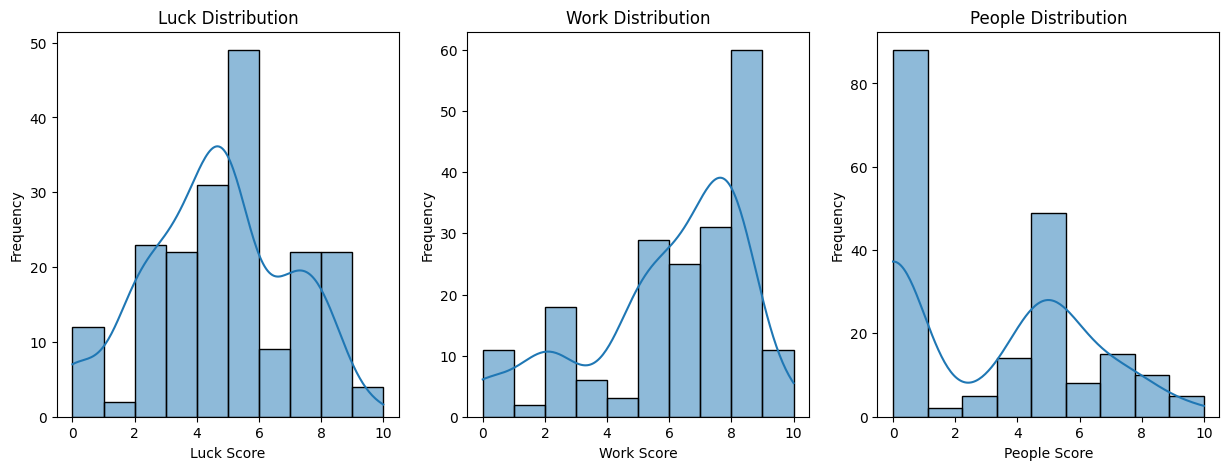

In [18]:
filtered_df = df[df["answer"] != "Question/Answer not found"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(filtered_df["luck"], kde=True, ax=ax[0])
ax[0].set_title("Luck Distribution")
ax[0].set_xlabel("Luck Score")
ax[0].set_ylabel("Frequency")

sns.histplot(filtered_df["work"], kde=True, ax=ax[1])
ax[1].set_title("Work Distribution")
ax[1].set_xlabel("Work Score")
ax[1].set_ylabel("Frequency")

sns.histplot(filtered_df["people"], kde=True, ax=ax[2])
ax[2].set_title("People Distribution")
ax[2].set_xlabel("People Score")
ax[2].set_ylabel("Frequency")


In [11]:
companies = MONGODB_COLLECTION.aggregate([
    {"$group": {"_id": "$company", "guest": {"$first": "$guest"}}},
    {"$project": {"_id": 0, "company": "$_id", "guest": 1}},
])
companies = [{"company": company["company"], "guest": company["guest"]} for company in companies]


In [13]:
# turn this into a pandas dataframe and attach guest to filtered_df
companies_df = pd.DataFrame(companies)
companies_df = companies_df.rename(columns={"company": "company", "guest": "guest"})
filtered_df = filtered_df.merge(companies_df, on="company")

In [14]:
filtered_df.dropna(subset=["guest"], inplace=True)

,company,answer,summary,luck,work,people,guest
0,The Tetris Company,"Oh, it's, it's all because of hard work. I mea...",Success is attributed mainly to hard work and ...,0,10,0,Henk Rogers
1,Crate & Barrel,"Well, the lucky part was our timing and was ju...",The success is attributed to a combination of ...,5,5,5,Gordon Segal (2017)
2,Brooklinen,"There's a mix. I mean, I think it's lucky. The...",The guest believes that their success is a mix...,4,6,5,Vicki and Rich Fulop
3,Eleven Madison Park,I think so much of random chance and luck. I'v...,The guest attributes much of their success to ...,7,8,5,Daniel Humm
4,Aviator Nation,"I think that it's, it's really the hard work. ...",The guest attributes their success mostly to h...,2,8,5,Paige Mycoskie
...,...,...,...,...,...,...,...
191,M.M.LaFleur,It's 99% luck. I always go back to that experi...,Success is perceived as 99% luck with the exam...,9,1,0,Sarah LaFleur
192,Alamo Drafthouse Cinema,I would say that a lot of it has to do with ha...,Success is attributed to a combination of hard...,3,7,5,Tim and Karrie League
193,Impossible Foods,I think the most important thing is I feel lik...,Initiative and determination are the key attri...,2,8,5,Pat Brown
194,inov-8,I think it is a combination of them both becau...,Success is attributed to a combination of luck...,5,5,5,Wayne Edy


In [ ]:

def display_quoted_text(row):
    answer = row['answer']
    guest = row['guest']
    company = row['company']
    luck = row['luck']
    work = row['work']
    people = row['people']

    quoted_text = f'"{answer}" - {guest}, {company}\nLuck: {luck}, Work: {work}, People: {people}'
    return quoted_text